# 1. Set Up the Notebook

First, ensure that the necessary modules are correctly imported from your project. Then, load some sample data to test the GARCH parameter optimizer.

# 2. Importing the Necessary Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from garch_optimizer.garch_optimizer import garch_parameter
from sklearn.metrics import mean_absolute_percentage_error
from arch import arch_model

# 3. Generating Sample Data

Generate or load some sample time series data. For testing purposes, you can simulate some financial data.

In [3]:
np.random.seed(42)
n = 500
returns = np.random.normal(0, 1, n)

# Simulating volatility clustering
volatility = np.zeros_like(returns)
volatility[0] = 1

for i in range(1, n):
    volatility[i] = np.sqrt(0.01 + 0.9 * volatility[i-1]**2 + 0.05 * returns[i-1]**2)

# Generate returns with GARCH effects
garch_returns = volatility * returns

# Convert to a DataFrame
df = pd.DataFrame(garch_returns, columns=["returns"])
df["date"] = pd.date_range(start="2022-01-01", periods=n)
df.set_index("date", inplace=True)
df.head()

,returns
date,
2022-01-01,0.496714
2022-01-02,-0.132787
2022-01-03,0.593990
2022-01-04,1.351922
2022-01-05,-0.213980


# 4. Running the GARCH Parameter Optimization

Use the `GARCH_Parameter` function to perform the hyperparameter optimization on the generated data.

In [4]:
best_params = garch_parameter(
    data=df["returns"], 
    max_p=2, 
    max_q=2, 
    max_o=1, 
    max_lag=1, 
    n_trials=10
)

[I 2024-09-04 18:57:35,857] A new study created in memory with name: no-name-25f34729-0dcd-422d-b33c-1d2c051bcbd9


  0%|          | 0/10 [00:00<?, ?it/s]

Best Parameters: {'p': 1, 'q': 1, 'o': 0, 'lags': 1, 'mean_model': 'zero', 'vol_model': 'egarch', 'error_dist': 'normal'}
Best Score: 51157.85890557314
Elapsed Time: 00:00:01.36
Best Parameters: {'p': 1, 'q': 1, 'o': 0, 'lags': 1, 'mean_model': 'zero', 'vol_model': 'egarch', 'error_dist': 'normal'}


# 5. Visualizing the Results

You can visualize the true volatility and the model's predicted conditional volatility to assess the quality of the model fit.

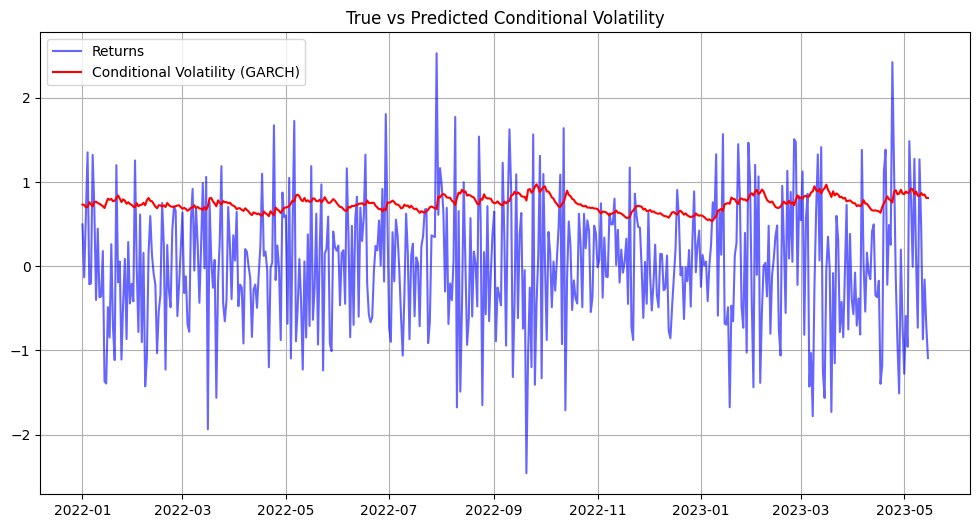

In [7]:
# Create a model with the best parameters
model = arch_model(df["returns"], mean=best_params['mean_model'], vol=best_params['vol_model'], 
                   p=best_params['p'], q=best_params['q'], o=best_params['o'], lags=best_params['lags'], 
                   rescale=True, dist=best_params['error_dist'])
model_fit = model.fit(disp='off')

# Add predictions to the DataFrame
df["Conditional Volatility"] = model_fit.conditional_volatility

# Plotting the true vs predicted volatility
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["returns"], label="Returns", color='blue', alpha=0.6)
plt.plot(df.index, df["Conditional Volatility"], label="Conditional Volatility (GARCH)", color='red')
plt.title("True vs Predicted Conditional Volatility")
plt.legend()
plt.grid()
plt.show()

# 6. Evaluating the Model

You can evaluate the model's performance using metrics like Mean Absolute Percentage Error (MAPE).

In [6]:
true_volatility = df['returns'].ewm(3).std()
mape = mean_absolute_percentage_error(true_volatility[1:], df["Conditional Volatility"][1:])

print(f"MAPE between True and Predicted Volatility: {mape:.4f}")

MAPE between True and Predicted Volatility: 0.2409
